In [88]:
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
# loading full dataframe
final_df = pd.read_csv('final_df.csv')

In [90]:
# dropping the track_id
final_df.drop(['track_id'], axis=1, inplace=True)
final_df

,title,artist,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Crazy - Single Version,"Patsy Cline, The Jordanaires",country,0.471,0.021,10,-24.385,1,0.0366,0.931000,0.000001,0.1030,0.356,107.796
1,Folsom Prison Blues,"Johnny Cash, The Tennessee Two",country,0.754,0.540,5,-8.326,1,0.0266,0.687000,0.000075,0.0868,0.790,101.738
2,I Will Always Love You,Dolly Parton,country,0.446,0.142,9,-13.498,1,0.0335,0.960000,0.001140,0.1010,0.156,135.724
3,Springsteen,Eric Church,country,0.692,0.809,2,-5.935,1,0.0255,0.100000,0.000098,0.1850,0.927,104.023
4,He Stopped Loving Her Today,George Jones,country,0.430,0.173,8,-18.597,1,0.0321,0.594000,0.000111,0.2240,0.365,72.103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7911,Alpha Centauri,Fergie,techno,0.569,0.983,1,-4.547,1,0.0816,0.000204,0.907000,0.0547,0.356,129.976
7912,The Future,"CamelPhat, Rebūke",techno,0.599,0.910,6,-7.403,0,0.1070,0.000116,0.876000,0.1500,0.110,128.020
7913,Vibrant,LEVT,techno,0.612,0.905,1,-7.154,0,0.0615,0.000170,0.887000,0.0632,0.398,132.000
7914,Zero Gravity,Ramon Tapia,techno,0.637,0.931,2,-3.093,1,0.0449,0.000198,0.877000,0.3580,0.530,133.993


In [91]:
genre_count = final_df['genre'].value_counts()

### Handling Data Imbalance

In [92]:
genre_count

house        1285
pop          1056
rock          995
country       747
metal         685
hiphop        681
techno        547
dance         522
jazz          487
kpop          397
classical     276
rnb           238
Name: genre, dtype: int64

In [93]:
# setting a minimum number of sample for each genre
min_genre_count = 800

In [94]:
# genres with samples more than min_genre_count
genre_count[genre_count > min_genre_count].index

Index(['house', 'pop', 'rock'], dtype='object')

In [95]:
# retaining data for genres with samples more than min_genre_count
genre_house = final_df[final_df['genre'] == 'house']
genre_pop = final_df[final_df['genre'] == 'pop']
genre_rock = final_df[final_df['genre'] == 'rock']

In [96]:
# genres with samples less than min_genre_count
genre_count[genre_count < min_genre_count].index

Index(['country', 'metal', 'hiphop', 'techno', 'dance', 'jazz', 'kpop',
       'classical', 'rnb'],
      dtype='object')

In [97]:
# upsampling data for genres with samples less than min_genre_count
genre_country = final_df[final_df['genre']=='country'].sample(min_genre_count, replace=True)
genre_metal = final_df[final_df['genre']=='metal'].sample(min_genre_count, replace=True)
genre_hiphop = final_df[final_df['genre']=='hiphop'].sample(min_genre_count, replace=True)
genre_techno = final_df[final_df['genre']=='techno'].sample(min_genre_count, replace=True)
genre_dance = final_df[final_df['genre']=='dance'].sample(min_genre_count, replace=True)
genre_jazz = final_df[final_df['genre']=='jazz'].sample(min_genre_count, replace=True)
genre_kpop = final_df[final_df['genre']=='kpop'].sample(min_genre_count, replace=True)
genre_classical = final_df[final_df['genre']=='classical'].sample(min_genre_count, replace=True)
genre_rnb = final_df[final_df['genre']=='rnb'].sample(min_genre_count, replace=True)

In [98]:
# concatetnating all genre dataframes after upsampling
upsampled_df = pd.concat([genre_house, genre_pop, genre_rock, genre_country, genre_metal, genre_hiphop, genre_techno, genre_dance, genre_jazz,  genre_kpop, genre_classical, genre_rnb], axis=0)

In [99]:
# computing supposed total numbers of tracks after upsampling
genre_count[genre_count > min_genre_count].values.sum()+len(genre_count[genre_count < min_genre_count].index)*min_genre_count

10536

In [100]:
# checking total numbers of tracks in new dataframe
len(upsampled_df)

10536

In [105]:
# resetting index
upsampled_df.reset_index(drop=True, inplace=True)

### Clustering
#### Scaling Data

In [106]:
# creating a dataframe for only audio features
X = upsampled_df.drop(columns=['title','artist', 'genre'])

In [108]:
# scaling the audio features dataframe
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.head())
print()
display(X_scaled_df.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.721,0.923,11,-4.497,0,0.0370,0.00299,0.03120,0.0989,0.575,128.748
1,0.805,0.660,5,-11.972,0,0.0897,0.01790,0.29500,0.3340,0.147,133.002
2,0.722,0.990,7,-5.103,1,0.0667,0.02090,0.00186,0.2620,0.398,122.991
3,0.691,0.830,0,-9.189,1,0.0450,0.06010,0.75800,0.4050,0.830,128.912
4,0.761,0.808,11,-5.629,0,0.0518,0.00258,0.00003,0.0869,0.157,119.931


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.606474,0.949054,1.590727,0.669158,-1.150555,-0.607405,-0.694318,-0.549015,-0.543965,0.289980,0.318752
1,1.072358,-0.048919,-0.095945,-0.574938,-1.150555,0.056452,-0.646297,0.215029,1.051954,-1.394319,0.477718
2,0.612020,1.203290,0.466279,0.568299,0.869146,-0.233277,-0.636635,-0.633992,0.563199,-0.406564,0.103620
3,0.440087,0.596158,-1.501505,-0.111751,0.869146,-0.506630,-0.510382,1.556015,1.533920,1.293477,0.324880
4,0.828324,0.512678,1.590727,0.480755,-1.150555,-0.420971,-0.695639,-0.639293,-0.625424,-1.354967,-0.010728


### Clustering
#### Elbow Method

Training a K-Means model with 2 clusters! 

Training a K-Means model with 3 clusters! 

Training a K-Means model with 4 clusters! 

Training a K-Means model with 5 clusters! 

Training a K-Means model with 6 clusters! 

Training a K-Means model with 7 clusters! 

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 

Training a K-Means model with 11 clusters! 

Training a K-Means model with 12 clusters! 

Training a K-Means model with 13 clusters! 

Training a K-Means model with 14 clusters! 

Training a K-Means model with 15 clusters! 

Training a K-Means model with 16 clusters! 

Training a K-Means model with 17 clusters! 

Training a K-Means model with 18 clusters! 

Training a K-Means model with 19 clusters! 

Training a K-Means model with 20 clusters! 

Training a K-Means model with 21 clusters! 

Training a K-Means model with 22 clusters! 

Training a K-Means model with 23 clusters! 

Training a K-Means

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

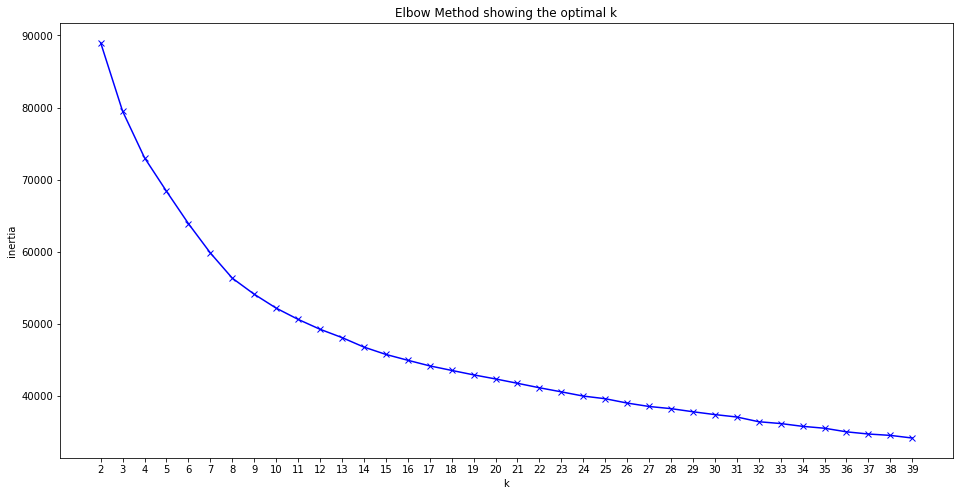

In [113]:
K = range(2, 40)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=345)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

### Clustering
#### Silhouette Method

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

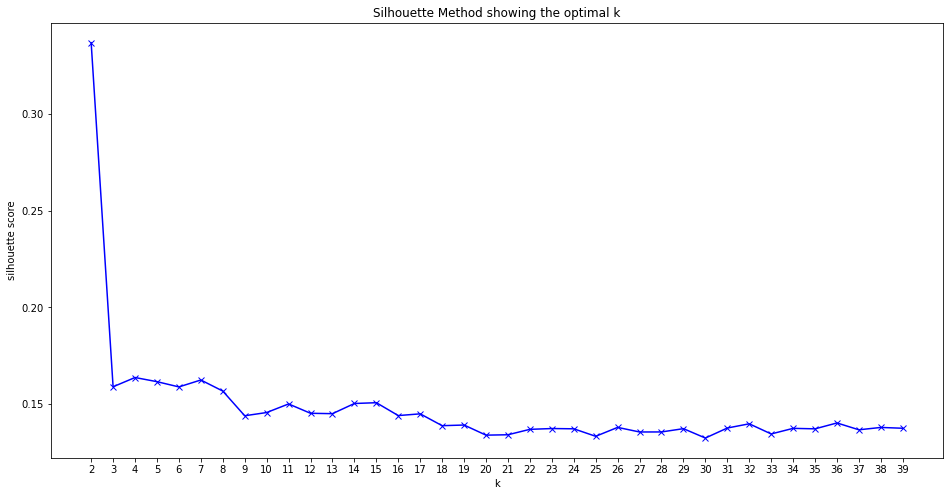

In [115]:
K = range(2, 40)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=345)
    kmeans.fit(X_scaled_df)
    
    filename = "Model/kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [116]:
import pickle
with open("Model/scaler.pickle", "wb") as f:
    pickle.dump(scaler,f)
with open("Model/kmeans_24.pickle", "wb") as f:
    pickle.dump(kmeans,f)

In [117]:
# setting up clusters
kmeans = KMeans(n_clusters=24, random_state=345)
kmeans.fit(X_scaled_df)

KMeans(n_clusters=24, random_state=345)

In [118]:
kmeans.inertia_

39974.48122112494

In [119]:
clusters = kmeans.predict(X_scaled_df)
pd.Series(clusters).value_counts().sort_index()

0     251
1     664
2     241
3     783
4     563
5     400
6     659
7     307
8     376
9     444
10    495
11    582
12    653
13    725
14    421
15    373
16    220
17    327
18    249
19    366
20    357
21    204
22    319
23    557
dtype: int64